In [1]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

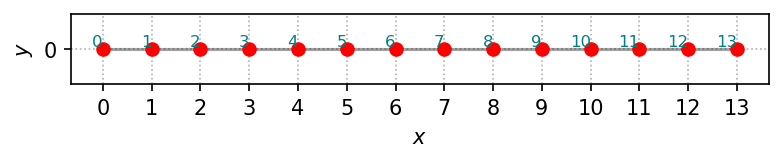

In [2]:
N = 14
lattice = ChainLattice(N, "open")

lattice.plot(True, c="r")
num_sites = lattice.get_num_sites()

lattice_sites = lattice.get_sites()
lattice_edges = lattice.get_edges()
reciprocal_lattice_sites = lattice.get_reciprocal_sites()

Lowest found energy:  4.5776368934923095e-05
Index of lowest absolute energy:  28


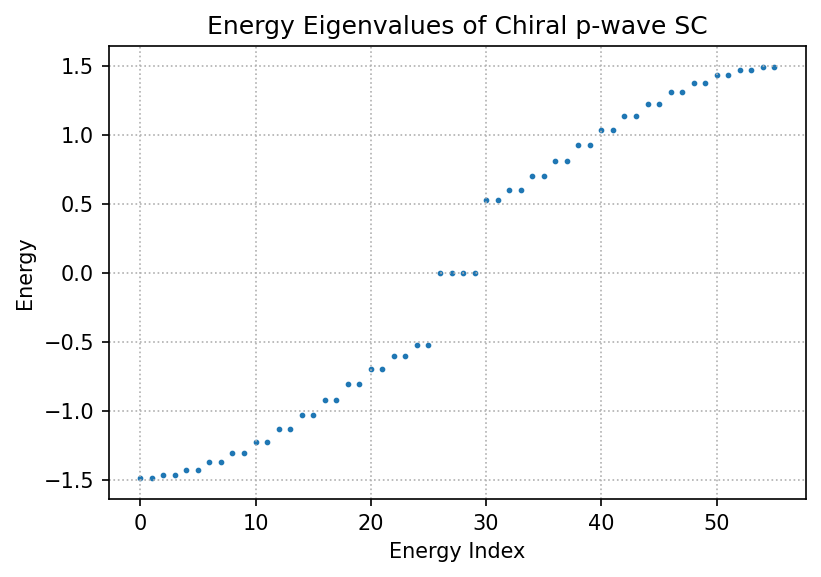

In [3]:
t = 1.0
mu = 0.5 * t
delta = complex(1.0, 0.0)
dim_H_BdG = 4

Ham_constructor = HamiltonianConstructor(mu, t, t, delta)

energies, states = scipy.linalg.eigh(
    Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
)
print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

plt.xlabel("Energy Index")
plt.ylabel("Energy")
plt.grid(linestyle=":")
plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=3)

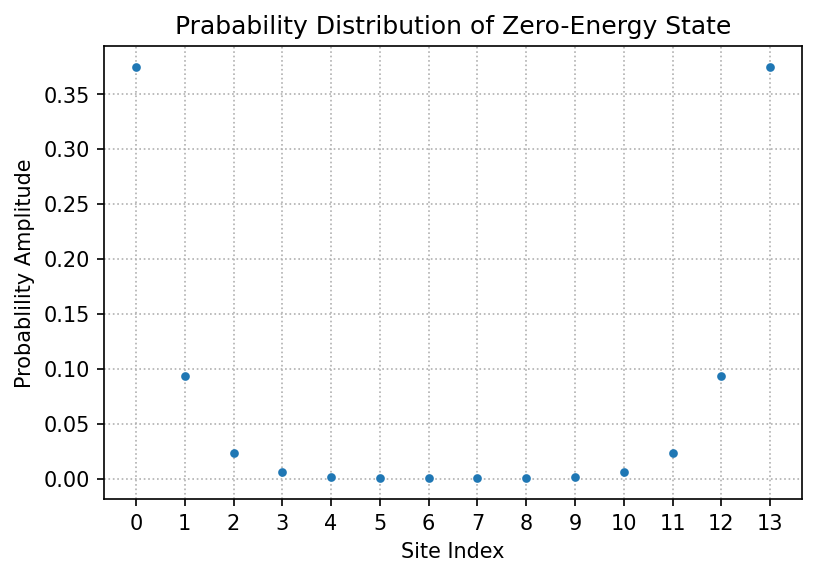

In [4]:
gs_wave_function = states[:, gs_idx]
gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
gs_probabilities = np.zeros(shape=(num_sites, 1))
block_indices = [
    slice(block_idx * dim_H_BdG, (block_idx + 1) * dim_H_BdG)
    for block_idx in range(lattice.get_num_sites())
]

for site_idx in range(num_sites):
    gs_probabilities[site_idx] = np.sum(gs_probabilities_nambu[block_indices[site_idx]])

plt.xlabel("Site Index")
plt.xticks(range(0, num_sites, num_sites // min(num_sites, 20)))
plt.ylabel("Probablility Amplitude")
plt.title("Prabability Distribution of Zero-Energy State")
plt.grid(linestyle=":", zorder=-10)
plt.scatter(range(num_sites), gs_probabilities, s=10, zorder=10)

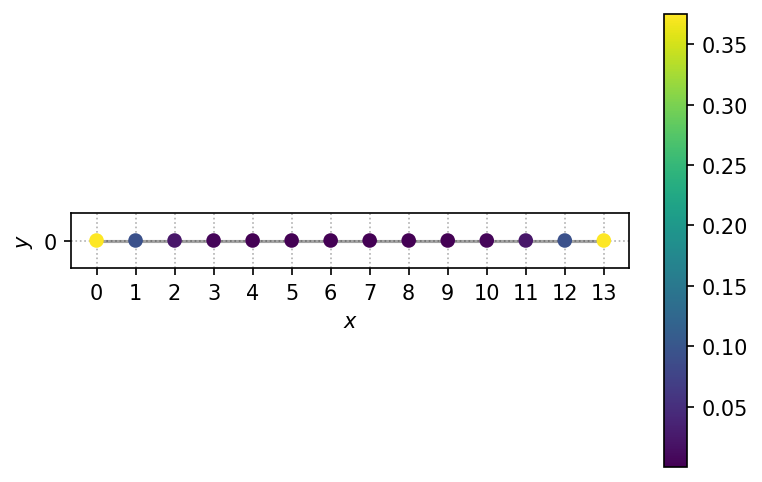

In [5]:
x_values = [k[0] for k in lattice_sites]
y_values = [k[1] for k in lattice_sites]

sc = lattice.plot(show_idx_bool=False, c=(gs_probabilities))
plt.colorbar(sc)